# Notes

This notebook fixes issues with Pipe_Creation_Plus_LSS.ipynb.

The old version calculated the percentage of cells whicch were of each structure type and stored them to be used with the DMs. However, as pointed out by Laura in our meeting on 09/12/21, multiplying total DM by these fractions would assume that each structure contributes an equal amount of DM. This is not true. Instead, we should store the dDM/dz values separately. These should be calculated using np.sum/10,0000 where 10,0000 is the total number of cells when considering EVERY structure type. In this way, dDM/dz for each type of structure will sum to equal dDM/dz total.

It builds upon the Zhang+20 method of creating DMs from the TNG simulation by identifying Large-Scale Structure 

The code builds upon the pipe creation code at: raven:/u/cwalker/Illustris_Zhang_Method/Pipe_Creation_Test.ipynb

It also builds upon the LSS code at: raven:/u/cwalker/Illustris_FRB_Project/git_Illustris_uploads/mass_fraction_plots/artale_test_121121/SCRIPT_Cel_Auto.py

and: raven:/u/cwalker/Illustris_FRB_Project/yt-artale-constants.ipynb

The original Zhang+20 method is from: https://arxiv.org/abs/2011.14494
The original Artale+21 method is from:  https://arxiv.org/abs/2102.01092


# Imports

In [1]:
import illustris_python as il
import numpy as np
from numpy import random as rand
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import binned_statistic_dd
from astropy import constants as c
#from artale_constants import *
from astropy.cosmology import Planck15 as cosmosource


# Functions

In [2]:
def gadgetDens2SI(dens):
    """
    Original Artale function to convert TNG densities to SI units

    INPUTSRETURNS:

    dens : [values] densities from TNG

    RETURNS:

    dens converted to SI units
    """
    return dens*1E10*cel_Msol_si/cel_hubble/(cel_kpc_si/cel_hubble)**3

def TNG_Dens2SI(dens):
    """
    Like gadgetDens2SI but using astropy values for constants
    Strips result of units
    Developed in raven:/u/cwalker/Illustris_FRB_Project/yt-artale-constants.ipynb


    INPUTSRETURNS:

    dens : [values] densities from TNG

    RETURNS:

    dens converted to SI units
    """
    return dens*1E10*c.M_sun.to('kg').value/cosmosource.h/(c.kpc.to('m').value/cosmosource.h)**3

def TNG_Dens2SI_astropy(dens):
    """
    Like TNG_Dens2SI but does not strip result of units.
    Developed in raven:/u/cwalker/Illustris_FRB_Project/yt-artale-constants.ipynb


    INPUTSRETURNS:

    dens : [values] densities from TNG

    RETURNS:

    dens converted to SI units
    """

    return dens*1E10*c.M_sun.to('kg')/cosmosource.h/(c.kpc.to('m')/cosmosource.h)**3

   
    
    


# Begin

From paper:

"For computational simplicity, the line of sight is chosen parallel
to the X-axis, which is similar to Jaroszynski+19"

"Then we make 5125 square pipes with 200ckpc/h side in each snapshot
and find the particles as well as necessary parameters including
Coordinates, Density, ElectronAbundance, GFM_Metals, and StarFormationRate.
The 5125 pipes are chosen from different locations at 24 snapshots randomly"

"We divide the pipe into
10,000 bins along the x axis and take the geometric center coordinates as the representation of bins."

"We take an average of the electron density
of 10,000 bins and put it into equation (7). As a result,
5125 dDMIGM/dz are obtained at each redshift."





# Step: load data and initialise

In [32]:
npipes      = 1  #number of pipes to create
snap_number = 99 #snapshot number for test

###########
#load data#
###########

#simulation to use
sim_to_use = 'TNG50-3'
#base path to simulation
basePath = '/ptmp/cwalker/Illustris_FRB_Project/TNG_copies/virgo/simulations/IllustrisTNG/{0}/output/'.format(sim_to_use)
basePath = '/virgo/simulations/IllustrisTNG/{0}/output/'.format(sim_to_use)

print('Loading Simulation: {0}'.format(sim_to_use))
#gas, i.e. partType0 data to load
dataPT0 = il.snapshot.loadSubset(basePath, snap_number, 'gas', fields=['Density',
                                                                       'ElectronAbundance',
                                                                       'StarFormationRate',
                                                                       'Coordinates',
                                                                       'Masses',
                                                                       'SubfindDMDensity'])
#star, i.e. partType4 data to load
#dataPT4 = il.snapshot.loadSubset(basePath, snap_number, 'star', fields=['Masses',
#                                                                        'SubfindDMDensity',
#                                                                        'Coordinates'])
#Note: as we're only looking at the ionised material along the pipes, I don't think we actually need star data.
#It may be worth thinking about this at a later date.

#load header
header = il.groupcat.loadHeader(basePath,snap_number)

print(header)
print(dataPT0['Coordinates'].shape)
#print(dataPT4['Coordinates'].shape)

Loading Simulation: TNG50-3
{'BoxSize': 35000.0, 'FlagDoubleprecision': 0, 'Git_commit': b'd203ec8b07c7e2bdda5f608aa0babea46d603699', 'Git_date': b'Thu Apr 7 14:14:27 2016 +0200', 'HubbleParam': 0.6774, 'Ngroups_ThisFile': 3, 'Ngroups_Total': 175460, 'Nids_ThisFile': 11859544, 'Nids_Total': 131744734, 'Nsubgroups_ThisFile': 3430, 'Nsubgroups_Total': 134779, 'NumFiles': 11, 'Omega0': 0.3089, 'OmegaLambda': 0.6911, 'Redshift': 2.220446049250313e-16, 'Time': 0.9999999999999998}
(144958247, 3)


In [33]:
print(dataPT0)
print(dataPT0['Coordinates'])
print(dataPT0['Density'].shape)
print(dataPT0['Coordinates'].shape)
print(header['Redshift'])
print(TNG_Dens2SI_astropy(dataPT0['Density']))
print(cosmosource.H(0))
print(c.c*1)
print((c.c*1)/(cosmosource.H(0)))




{'count': 144958247, 'Density': array([6.3368898e-05, 6.1842016e-05, 6.1400053e-05, ..., 1.8275015e-08,
       8.7597918e-08, 5.9600080e-07], dtype=float32), 'ElectronAbundance': array([1.1674018, 1.1674217, 1.1665777, ..., 1.1578674, 1.1579686,
       1.1547354], dtype=float32), 'StarFormationRate': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), 'Coordinates': array([[ 7306.64651812, 24560.8577112 , 21306.32494358],
       [ 7305.89040148, 24560.90186494, 21305.20633905],
       [ 7307.27472709, 24560.59850535, 21305.14673921],
       ...,
       [29535.98184956, 32210.43232902, 10718.70243578],
       [15907.90786558, 28623.52838429, 25589.28362463],
       [ 5037.42093562, 22413.35733358, 17658.43730249]]), 'Masses': array([0.00026305, 0.00033502, 0.00040849, ..., 0.00042847, 0.00038712,
       0.00040419], dtype=float32), 'SubfindDMDensity': array([1.05117626e-01, 9.00989845e-02, 1.23970844e-01, ...,
       6.31903490e-08, 2.98767020e-07, 3.19919479e-07], dtype=float32)}
[[ 7

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: overflow encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


[1.96798060e-23 1.92056206e-23 1.90683620e-23 ... 5.67547744e-27
 2.72043559e-26 1.85093647e-25] kg / m3
67.74 km / (Mpc s)
299792458.0 m / s
4425634.16002362 m Mpc / km


In [34]:
#averages test
sample = np.arange(30)
print(sample,np.mean(sample))
reshaped = sample.reshape(3,10)
print(reshaped,np.mean(reshaped,axis=1),np.sum(np.mean(reshaped,axis=1)),np.mean(np.mean(reshaped,axis=1)))
reshaped2 = np.array([np.array([0,1,2,3,4,5]),np.array([6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]),np.array([22,23,24,25,26,27,28,29])])
print(reshaped2,np.array([np.mean(reshaped2[0]),np.mean(reshaped2[1])]))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29] 14.5
[[ 0  1  2  3  4  5  6  7  8  9]
 [10 11 12 13 14 15 16 17 18 19]
 [20 21 22 23 24 25 26 27 28 29]] [ 4.5 14.5 24.5] 43.5 14.5
[array([0, 1, 2, 3, 4, 5])
 array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21])
 array([22, 23, 24, 25, 26, 27, 28, 29])] [ 2.5 13.5]


# Test 1: create dDM/dz values for each type of structure directly

In [35]:

############
#initialise#
############

#The number of cells in the chosen snapshot
ncells = dataPT0['Coordinates'].shape[0]
print('Number of cells in snapshot {0} is {1}'.format(snap_number,ncells))

#The width of the pipe
pipe_width = 200 #By following zhang+20 definition, sides will be 200ckpc/h in length
print('Pipe width will be {0} ckpc/h'.format(pipe_width))

#The number of bins along a single line of sight
nbins=10000 #Zhang+20 definition: 10,000
print('There will be {0} bins on each sightline'.format(nbins))

#Define the mass of a proton for dDM/dz calculations
protonmass = c.m_p.to('kg')
print('Proton mass is {0}'.format(protonmass))

#Define the hydrogen mass fraction for dDM/dz calculations
hmassfrac = 3./4.
print('Chosen H mass fraction is {0}. Check whether this is correct'.format(hmassfrac))

#calculate the critical density at redshift zero for structure categorisation
#source to formula: https://astronomy.swin.edu.au/cosmos/c/Critical+Density
grav=c.G.to('m**3/(kg*s**2)') #g as a YT quantity in correct units
H=cosmosource.H(0).to('km/s/Mpc') #hubble const at z=0 in km/s/Mpc
my_dens_crit = ((3 * H**2)/(8*np.pi* grav)).to('kg/m**3')
print('Critical density at z=0 = {0}'.format(my_dens_crit))




Number of cells in snapshot 99 is 144958247
Pipe width will be 200 ckpc/h
There will be 10000 bins on each sightline
Proton mass is 1.67262192369e-27 kg
Chosen H mass fraction is 0.75. Check whether this is correct
Critical density at z=0 = 8.619160453152573e-27 kg / m3


Creating pipe 0
Random start cell coordinates: [    0.         15177.63987797 10910.78657045]
Pipe end cell coordinates: [35000.         15177.63987797 10910.78657045]
[(0.0, 35000.0), (15177.63987797208, 15177.63987797208), (10910.786570448177, 10910.786570448177)]
All y and z values: [[24560.8577112  21306.32494358]
 [24560.90186494 21305.20633905]
 [24560.59850535 21305.14673921]
 ...
 [32210.43232902 10718.70243578]
 [28623.52838429 25589.28362463]
 [22413.35733358 17658.43730249]]
Upper right: [15277.63987797 11010.78657045]
Lower left: [15077.63987797 10810.78657045]
4823 cells in this pipe
sum for star forming check: 0.0
Pipe x-axis bin coordinates: [0.00000000e+00 3.50035004e+00 7.00070007e+00 ... 3.49929993e+04
 3.49964996e+04 3.50000000e+04] ckpc/h
Pipe x-bin_coords: [[0.00000000e+00 1.51776399e+04 1.09107866e+04]
 [3.50035004e+00 1.51776399e+04 1.09107866e+04]
 [7.00070007e+00 1.51776399e+04 1.09107866e+04]
 ...
 [3.49929993e+04 1.51776399e+04 1.09107866e+04]
 [3.49964996e+0

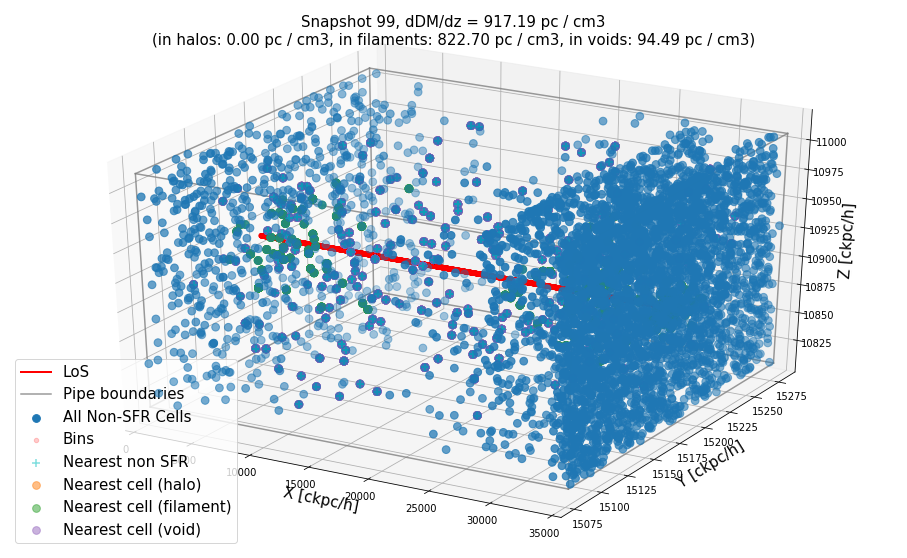

In [36]:
###################
#initialise figure#
###################

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111,projection='3d')
ax.set_xlim(0,header['BoxSize'])
ax.set_xlabel('X [ckpc/h]',fontsize=15)
ax.set_ylabel('Y [ckpc/h]',fontsize=15)
ax.set_zlabel('Z [ckpc/h]',fontsize=15)

#############
#Create Pipe#
#############

for i in range(npipes): #for each desired pipe
    
    pipe_number = i
    print('Creating pipe {0}'.format(pipe_number))

    #########################################
    #define los coordinates at start of pipe#
    #########################################
    
    #By Zhang+20 definition of following x-axis,
    #x will be zero, y and z will be random
    #units default = ckpc/h (compare box size to https://www.tng-project.org/about/)
    
    pipe_start_coords = np.array([0,
                         np.random.uniform(0,header['BoxSize'],1)[0],
                         np.random.uniform(0,header['BoxSize'],1)[0]])
    print('Random start cell coordinates: {0}'.format(pipe_start_coords))
    
    ###################################
    #define coordinates at end of pipe#
    ###################################
    
    #By Zhang+20 definition of following x-axis,
    #x will be length of simulation,y and z will be same as start coords
    
    pipe_end_coords = pipe_start_coords+np.array([header['BoxSize'],0,0])
    print('Pipe end cell coordinates: {0}'.format(pipe_end_coords))

    ########################
    #plot the line of sight#
    ########################
    
    los_toplot=list(zip(pipe_start_coords,pipe_end_coords))
    print(los_toplot)
    ax.plot(los_toplot[0],
            los_toplot[1],
            los_toplot[2],
            color='r',lw=2,label='LoS')
    
    ########################
    #construct pipe corners#
    ########################
    
    #Add and subtract half of pipe length from y and z coords for y and z boundaries
    #code adapted from https://stackoverflow.com/questions/33540109/plot-surfaces-on-a-cube
    
    c1s = pipe_start_coords + np.array([0,pipe_width/2,pipe_width/2]) #start corner 1
    c2s = pipe_start_coords + np.array([0,-pipe_width/2,-pipe_width/2]) #start corner 2
    c3s = pipe_start_coords + np.array([0,pipe_width/2,-pipe_width/2]) #start corner 3
    c4s = pipe_start_coords + np.array([0,-pipe_width/2,pipe_width/2]) #start corner 4
    
    c1e = pipe_end_coords + np.array([0,pipe_width/2,pipe_width/2]) #end corner 1
    c2e = pipe_end_coords + np.array([0,-pipe_width/2,-pipe_width/2]) #end corner 2
    c3e = pipe_end_coords + np.array([0,pipe_width/2,-pipe_width/2]) #end corner 3
    c4e = pipe_end_coords + np.array([0,-pipe_width/2,pipe_width/2]) #end corner 4
    
    corners = np.array([c1s,c2s,c3s,c4s,c1e,c2e,c3e,c4e])
    
    ######################
    #construct pipe edges#
    ######################

    line1 = list(zip(c1s,c1e))
    line2 = list(zip(c2s,c2e))
    line3 = list(zip(c3s,c3e))
    line4 = list(zip(c4s,c4e))
    line5 = list(zip(c1s,c3s))
    line6 = list(zip(c3s,c2s))
    line7 = list(zip(c2s,c4s))
    line8 = list(zip(c4s,c1s))
    line9 = list(zip(c1e,c3e))
    line10 = list(zip(c3e,c2e))
    line11 = list(zip(c2e,c4e))
    line12 = list(zip(c4e,c1e))
    
    lines_todraw = np.array([line1,line2,line3,line4,line5,line6,line7,line8,line9,line10,line11,line12])
    

    ###########
    #plot pipe#
    ###########
    
    for i in range(len(lines_todraw)):
        if i==0:
            ax.plot(lines_todraw[i][0],
                    lines_todraw[i][1],
                    lines_todraw[i][2],
                    color='gray',alpha=0.8,label='Pipe boundaries')
        else:
            ax.plot(lines_todraw[i][0],
                    lines_todraw[i][1],
                    lines_todraw[i][2],
                    color='gray',alpha=0.8)

    ########################
    #get cells in this pipe#
    ########################
    
    #adapted from https://stackoverflow.com/questions/42352622/finding-points-within-a-bounding-box-with-numpy
    #I think this is right but if I get any strange results, double check the theory
    
    yz_pts = dataPT0['Coordinates'][:,[1,2]] #all y and z coords
    print('All y and z values: {0}'.format(yz_pts))

    ur = c1s[1:] #upper right of pipe start (y and z only)
    ll = c2e[1:] #lower left of pipe end (y and z only)
    print('Upper right: {0}'.format(ur))
    print('Lower left: {0}'.format(ll))

    inidx = np.all((ll <= yz_pts) & (yz_pts <= ur), axis=1) #indexes of cells in pipe
    
    ###########################
    #get data of cells in pipe#
    ###########################
    
    pipe_cell_coords = dataPT0['Coordinates'][inidx]       #coordinates [ckpc/h]
    pipe_cell_dens   = dataPT0['Density'][inidx]           #densities [(1e10Msun/h)/(ckpc/h)**3]
    pipe_cell_elab   = dataPT0['ElectronAbundance'][inidx] #electron abundance [-]
    pipe_cell_sfr    = dataPT0['StarFormationRate'][inidx] #star formation rate [Msun/yr]
    pipe_cell_dark   = dataPT0['SubfindDMDensity'][inidx]  #comoving dark matter density [(1e10Msun/h)/(ckpc/h)**3]
    
    print('{0} cells in this pipe'.format(dataPT0['Coordinates'][inidx].shape[0]))

    ###############################
    #plot locations of these cells#
    ###############################
    
    #ax.scatter3D(pipe_cell_coords[:,0],
    #             pipe_cell_coords[:,1],
    #             pipe_cell_coords[:,2],
    #             label='Cells',s=60)
    
    
    ############################################################
    #For pure Zhang+20 method, exclude all star forming regions#
    ############################################################
    
    pipe_cell_coords_z = pipe_cell_coords[np.where(pipe_cell_sfr==0)]
    pipe_cell_dens_z = pipe_cell_dens[np.where(pipe_cell_sfr==0)]
    pipe_cell_elab_z = pipe_cell_elab[np.where(pipe_cell_sfr==0)]
    pipe_cell_sfr_z = pipe_cell_sfr[np.where(pipe_cell_sfr==0)]
    pipe_cell_dark_z = pipe_cell_dark[np.where(pipe_cell_sfr==0)]
    
    print('sum for star forming check: {0}'.format(pipe_cell_sfr_z.sum()))
    
    ###############################
    #plot locations of these cells#
    ###############################
    
    ax.scatter3D(pipe_cell_coords_z[:,0],
                 pipe_cell_coords_z[:,1],
                 pipe_cell_coords_z[:,2],
                 label='All Non-SFR Cells',s=60,color='C0',marker='o')
    
    ###############################################
    #divide pipe into 10,000 bins along the x-axis#
    ###############################################
    
    #Question: why 10,000 bins given there are so few particles in the pipe?
    
    pipe_x_bins = np.linspace(pipe_start_coords[0],pipe_end_coords[0],nbins)
    print('Pipe x-axis bin coordinates: {0} ckpc/h'.format(pipe_x_bins))
    
    #######################################
    #get coordinates of center of each bin#
    #######################################
    
    pipe_bin_coords = np.array([[i,pipe_start_coords[1],pipe_start_coords[2]]for i in pipe_x_bins])
    print('Pipe x-bin_coords: {0}'.format(pipe_bin_coords))
    
    #plot locations of these bins
    ax.scatter3D(pipe_bin_coords[:,0],
             pipe_bin_coords[:,1],
             pipe_bin_coords[:,2],
             label='Bins',color='r',alpha=0.2)
    
    ###############################################################
    #for each bin, find distance between it and every cell in pipe#
    #find the one with miniimum distance                          #
    #this will be the cell in the los                             #
    #do for zhang (excluding sfr) and non-zhang (including sfr)   #
    ###############################################################
    
    ###########
    #non-zhang#
    ###########
    
    #initialise empty array to hold indices of closest particle to each bin
    nearest_idxs = []
    
    for i in range(len(pipe_bin_coords)): #loop over bins
        coords = pipe_bin_coords[i] #get bin coordinates
        distarr = np.sqrt(np.sum(((pipe_cell_coords[:]-coords)**2),axis=1)) #create array of distances from cells
        nearest = np.argmin(distarr) #find nearest cell to bin
        nearest_idxs.append(nearest) #append to array
        
    nearest_idxs = np.array(nearest_idxs) #convert to numpy array
    nearest_idxs_unique = np.unique(nearest_idxs) #some cells are the closest to multiple bins. Get uniques.
    
    ##############
    #zhang method#
    ##############
    
    #initialise empty array to hold indices of closest particle to each bin
    nearest_idxs_z = []
    
    for i in range(len(pipe_bin_coords)): #loop over bins
        coords = pipe_bin_coords[i] #get bin coordinates
        distarr = np.sqrt(np.sum(((pipe_cell_coords_z[:]-coords)**2),axis=1)) #create array of distances from cells
        nearest = np.argmin(distarr) #find nearest cell to bin
        nearest_idxs_z.append(nearest) #append to array
        
    nearest_idxs_z = np.array(nearest_idxs_z) #convert to numpy array
    nearest_idxs_unique_z = np.unique(nearest_idxs_z) #some cells are the closest to multiple bins. Get uniques.
    
    print('Nearest {0} particle ids: {1}'.format(np.shape(nearest_idxs),nearest_idxs))
    print('Of these, {0} are unique: {1}'.format(np.shape(nearest_idxs_unique),nearest_idxs_unique))
    
    #################################
    #extract data from nearest cells#
    #################################
    
    ###########
    #non-zhang#
    ###########
    
    pipe_nearest_coords = np.array(pipe_cell_coords[nearest_idxs]) #coordinates [ckpc/h]
    pipe_nearest_dens   = np.array(pipe_cell_dens[nearest_idxs])   #densities [(1e10Msun/h)/(ckpc/h)**3]
    pipe_nearest_elab   = np.array(pipe_cell_elab[nearest_idxs])   #electron abundance [-]
    pipe_nearest_sfr    = np.array(pipe_cell_sfr[nearest_idxs])    #star formation rate [Msun/yr]
    pipe_nearest_dark   = np.array(pipe_cell_dark[nearest_idxs])   #comooving dark matter density [(1e10Msun/h)/(ckpc/h)**3]
    
    #######
    #zhang#
    #######
    pipe_nearest_coords_z = np.array(pipe_cell_coords_z[nearest_idxs_z]) #coordinates [ckpc/h]
    pipe_nearest_dens_z   = np.array(pipe_cell_dens_z[nearest_idxs_z])   #densities [(1e10Msun/h)/(ckpc/h)**3]
    pipe_nearest_elab_z   = np.array(pipe_cell_elab_z[nearest_idxs_z])   #electron abundance [-]
    pipe_nearest_sfr_z    = np.array(pipe_cell_sfr_z[nearest_idxs_z])    #star formation rate [Msun/yr]
    pipe_nearest_dark_z   = np.array(pipe_cell_dark_z[nearest_idxs_z])   #comooving dark matter density [(1e10Msun/h)/(ckpc/h)**3]
    
    #mark locations of nearest cells to bins on plot
    #ax.scatter3D(pipe_nearest_coords[:,0],
    #         pipe_nearest_coords[:,1],
    #         pipe_nearest_coords[:,2],
    #         label='Nearest',color='k',marker='x',s=50)
    
    ax.scatter3D(pipe_nearest_coords_z[:,0],
             pipe_nearest_coords_z[:,1],
             pipe_nearest_coords_z[:,2],
             label='Nearest non SFR',color='C',marker='+',s=50,alpha=0.5)

    ###############################################
    #convert density to si units using artale code#
    ###############################################
    
    pipe_nearest_dens_si = TNG_Dens2SI_astropy(pipe_nearest_dens)    
    pipe_nearest_dens_z_si = TNG_Dens2SI_astropy(pipe_nearest_dens_z)
    
    ###########################################################
    #convert dark matter density to si units using artale code#
    ###########################################################
    
    pipe_nearest_dark_si = TNG_Dens2SI_astropy(pipe_nearest_dark)    
    pipe_nearest_dark_z_si = TNG_Dens2SI_astropy(pipe_nearest_dark_z) 
    
    #########################################################################
    #divide dark matter density by critical density to create the LSS tracer#
    #########################################################################
    
    pipe_nearest_LSStracer = pipe_nearest_dark_si/my_dens_crit
    pipe_nearest_LSStracer_z = pipe_nearest_dark_z_si/my_dens_crit
    print('The structure tracer array is {0}'.format(pipe_nearest_LSStracer_z))
    
    ##########################################
    #Create Large-Scale Structure (LSS) masks#
    ##########################################
    
    #non-zhang
    voi_mask_PT0 = pipe_nearest_LSStracer < 0.1
    fil_mask_PT0 = np.logical_and(pipe_nearest_LSStracer >= 0.1, pipe_nearest_LSStracer < 57)#CELESTE:CORRECTED
    hal_mask_PT0 = pipe_nearest_LSStracer >= 57 
    
    #zhang
    voi_mask_PT0_z = pipe_nearest_LSStracer_z < 0.1
    fil_mask_PT0_z = np.logical_and(pipe_nearest_LSStracer_z >= 0.1, pipe_nearest_LSStracer_z < 57)#CELESTE:CORRECTED
    hal_mask_PT0_z = pipe_nearest_LSStracer_z >= 57 
    
    #################################################
    #plot each structure type as a separate colour#
    #################################################
    
    #halos
    ax.scatter3D(pipe_nearest_coords_z[hal_mask_PT0_z][:,0],
             pipe_nearest_coords_z[hal_mask_PT0_z][:,1],
             pipe_nearest_coords_z[hal_mask_PT0_z][:,2],
             label='Nearest cell (halo)',color='C1',marker='o',s=60,alpha=0.5)

    #filaments
    ax.scatter3D(pipe_nearest_coords_z[fil_mask_PT0_z][:,0],
             pipe_nearest_coords_z[fil_mask_PT0_z][:,1],
             pipe_nearest_coords_z[fil_mask_PT0_z][:,2],
             label='Nearest cell (filament)',color='C2',marker='o',s=60,alpha=0.5)
    
    #voids
    ax.scatter3D(pipe_nearest_coords_z[voi_mask_PT0_z][:,0],
             pipe_nearest_coords_z[voi_mask_PT0_z][:,1],
             pipe_nearest_coords_z[voi_mask_PT0_z][:,2],
             label='Nearest cell (void)',color='C4',marker='o',s=60,alpha=0.5)
    
    ##########################################
    #get electron density at each of the bins#
    ##########################################
    
    #follow zhang+20 equation exactly as native units of TNG are
    #comoving
    
    #############################################################
    #Zhang: pne = (ElAb)*hmasssfrac*(Dens/protonmass)*((1+z)**3)#
    #use data which excludes SFRs                               #
    #############################################################
    
    #total
    pipe_nearest_pne_z = (pipe_nearest_elab_z)*hmassfrac*(pipe_nearest_dens_z_si/protonmass)*((1+header['Redshift'])**3)
    print('pnes are: {0}'.format(pipe_nearest_pne_z))

    #halos
    pipe_nearest_pne_z_hal = (pipe_nearest_elab_z[hal_mask_PT0_z])*hmassfrac*(pipe_nearest_dens_z_si[hal_mask_PT0_z]/protonmass)*((1+header['Redshift'])**3)
    print('pnes in halos are: {0}'.format(pipe_nearest_pne_z_hal))
    
    #filaments
    pipe_nearest_pne_z_fil = (pipe_nearest_elab_z[fil_mask_PT0_z])*hmassfrac*(pipe_nearest_dens_z_si[fil_mask_PT0_z]/protonmass)*((1+header['Redshift'])**3)
    print('pnes in filaments are: {0}'.format(pipe_nearest_pne_z_fil))
    
    #voids
    pipe_nearest_pne_z_voi = (pipe_nearest_elab_z[voi_mask_PT0_z])*hmassfrac*(pipe_nearest_dens_z_si[voi_mask_PT0_z]/protonmass)*((1+header['Redshift'])**3)
    print('pnes in voids are: {0}'.format(pipe_nearest_pne_z_voi))
    

    ######################################################################
    #Non-zhang: pne = (ElAb*Warm)*hmasssfrac*(Dens/protonmass)*((1+z)**3)#
    #use all data (sfr included) and warm mass fraction                  #
    ######################################################################    
    
    ##################################
    #average these electron densities#
    ##################################
    
    #Zhang method
    
    #total
    pipe_average_pne_z = np.mean(pipe_nearest_pne_z)
    print('Average pne is: {0}'.format(pipe_average_pne_z))

    #halos
    pipe_average_pne_z_hal = np.sum(pipe_nearest_pne_z_hal)/nbins
    print('Average pne in halos is: {0}'.format(pipe_average_pne_z_hal))
    
    #filaments
    pipe_average_pne_z_fil = np.sum(pipe_nearest_pne_z_fil)/nbins
    print('Average pne in filaments is: {0}'.format(pipe_average_pne_z_fil))
    
    #voids
    pipe_average_pne_z_voi = np.sum(pipe_nearest_pne_z_voi)/nbins
    print('Average pne in voids is: {0}'.format(pipe_average_pne_z_voi))
    
    ################################
    #calculate dDM/dz for this pipe#
    ################################
    
    #outer bit of eq 7
    outer=c.c/cosmosource.H(0)
    print(outer)

    #E(z) according to paper eq 5
    Ez = np.sqrt((0.3089*((1+header['Redshift'])**(3)))+(0.6911))
    print(Ez)
    
    #denominator of eq 7
    denominator = ((1+header['Redshift'])**(2))*Ez

    #remainder of equation 7
    
    #total
    edens_z = pipe_average_pne_z
    ddmdz_z = outer*edens_z/denominator
    
    #halos
    edens_z_hal = pipe_average_pne_z_hal
    ddmdz_z_hal = outer*edens_z_hal/denominator
    
    #filaments
    edens_z_fil = pipe_average_pne_z_fil
    ddmdz_z_fil = outer*edens_z_fil/denominator
    
    #voids
    edens_z_voi = pipe_average_pne_z_voi
    ddmdz_z_voi = outer*edens_z_voi/denominator
    
    print('dDM/dz = {0}'.format(ddmdz_z.to('pc*cm**(-3)')))
    print('dDM/dz in halos = {0}'.format(ddmdz_z_hal.to('pc*cm**(-3)')))
    print('dDM/dz in filaments = {0}'.format(ddmdz_z_fil.to('pc*cm**(-3)')))
    print('dDM/dz in voids = {0}'.format(ddmdz_z_voi.to('pc*cm**(-3)')))

    
    ax.set_title('Snapshot {0}, dDM/dz = {1:.2f}\n(in halos: {2:.2f}, in filaments: {3:.2f}, in voids: {4:.2f})'.format(snap_number,
                                                                                                                        ddmdz_z.to('pc*cm**(-3)'),
                                                                                                                        ddmdz_z_hal.to('pc*cm**(-3)'),
                                                                                                                        ddmdz_z_fil.to('pc*cm**(-3)'),
                                                                                                                        ddmdz_z_voi.to('pc*cm**(-3)')),fontsize=15)

    
    
plt.legend(fontsize=15)

# Test 2: Calculate only dDM/dz as above, but also recover percentage of cells used to get it which were in halos, filaments, and voids 

In [37]:

############
#initialise#
############

#The number of cells in the chosen snapshot
ncells = dataPT0['Coordinates'].shape[0]
print('Number of cells in snapshot {0} is {1}'.format(snap_number,ncells))

#The width of the pipe
pipe_width = 200 #By following zhang+20 definition, sides will be 200ckpc/h in length
print('Pipe width will be {0} ckpc/h'.format(pipe_width))

#The number of bins along a single line of sight
nbins=10000 #Zhang+20 definition: 10,000
print('There will be {0} bins on each sightline'.format(nbins))

#Define the mass of a proton for dDM/dz calculations
protonmass = c.m_p.to('kg')
print('Proton mass is {0}'.format(protonmass))

#Define the hydrogen mass fraction for dDM/dz calculations
hmassfrac = 3./4.
print('Chosen H mass fraction is {0}. Check whether this is correct'.format(hmassfrac))

#calculate the critical density at redshift zero for structure categorisation
#source to formula: https://astronomy.swin.edu.au/cosmos/c/Critical+Density
grav=c.G.to('m**3/(kg*s**2)') #g as a YT quantity in correct units
H=cosmosource.H(0).to('km/s/Mpc') #hubble const at z=0 in km/s/Mpc
my_dens_crit = ((3 * H**2)/(8*np.pi* grav)).to('kg/m**3')
print('Critical density at z=0 = {0}'.format(my_dens_crit))

Number of cells in snapshot 99 is 144958247
Pipe width will be 200 ckpc/h
There will be 10000 bins on each sightline
Proton mass is 1.67262192369e-27 kg
Chosen H mass fraction is 0.75. Check whether this is correct
Critical density at z=0 = 8.619160453152573e-27 kg / m3


Creating pipe 0
Random start cell coordinates: [    0.         11319.77758747 12983.96952403]
Pipe end cell coordinates: [35000.         11319.77758747 12983.96952403]
[(0.0, 35000.0), (11319.777587469702, 11319.777587469702), (12983.969524028162, 12983.969524028162)]
All y and z values: [[24560.8577112  21306.32494358]
 [24560.90186494 21305.20633905]
 [24560.59850535 21305.14673921]
 ...
 [32210.43232902 10718.70243578]
 [28623.52838429 25589.28362463]
 [22413.35733358 17658.43730249]]
Upper right: [11419.77758747 13083.96952403]
Lower left: [11219.77758747 12883.96952403]
1134 cells in this pipe
sum for star forming check: 0.0
Pipe x-axis bin coordinates: [0.00000000e+00 3.50035004e+00 7.00070007e+00 ... 3.49929993e+04
 3.49964996e+04 3.50000000e+04] ckpc/h
Pipe x-bin_coords: [[0.00000000e+00 1.13197776e+04 1.29839695e+04]
 [3.50035004e+00 1.13197776e+04 1.29839695e+04]
 [7.00070007e+00 1.13197776e+04 1.29839695e+04]
 ...
 [3.49929993e+04 1.13197776e+04 1.29839695e+04]
 [3.49964996e

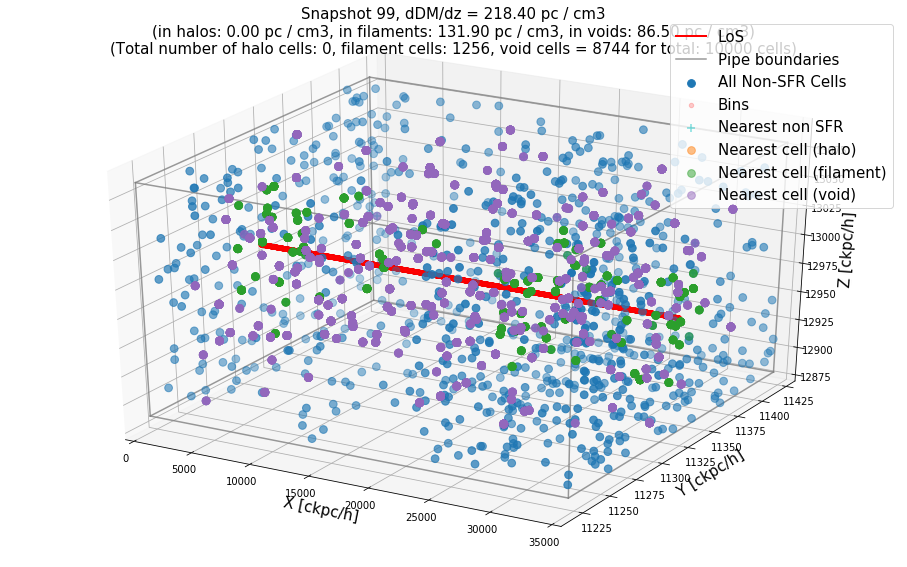

In [38]:
###################
#initialise figure#
###################

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111,projection='3d')
ax.set_xlim(0,header['BoxSize'])
ax.set_xlabel('X [ckpc/h]',fontsize=15)
ax.set_ylabel('Y [ckpc/h]',fontsize=15)
ax.set_zlabel('Z [ckpc/h]',fontsize=15)

#############
#Create Pipe#
#############

for i in range(npipes): #for each desired pipe
    
    pipe_number = i
    print('Creating pipe {0}'.format(pipe_number))

    #########################################
    #define los coordinates at start of pipe#
    #########################################
    
    #By Zhang+20 definition of following x-axis,
    #x will be zero, y and z will be random
    #units default = ckpc/h (compare box size to https://www.tng-project.org/about/)
    
    pipe_start_coords = np.array([0,
                         np.random.uniform(0,header['BoxSize'],1)[0],
                         np.random.uniform(0,header['BoxSize'],1)[0]])
    print('Random start cell coordinates: {0}'.format(pipe_start_coords))
    
    ###################################
    #define coordinates at end of pipe#
    ###################################
    
    #By Zhang+20 definition of following x-axis,
    #x will be length of simulation,y and z will be same as start coords
    
    pipe_end_coords = pipe_start_coords+np.array([header['BoxSize'],0,0])
    print('Pipe end cell coordinates: {0}'.format(pipe_end_coords))
    
    ########################
    #plot the line of sight#
    ########################
    
    los_toplot=list(zip(pipe_start_coords,pipe_end_coords))
    print(los_toplot)
    ax.plot(los_toplot[0],
            los_toplot[1],
            los_toplot[2],
            color='r',lw=2,label='LoS')
    
    ########################
    #construct pipe corners#
    ########################
    
    #Add and subtract half of pipe length from y and z coords for y and z boundaries
    #code adapted from https://stackoverflow.com/questions/33540109/plot-surfaces-on-a-cube
    
    c1s = pipe_start_coords + np.array([0,pipe_width/2,pipe_width/2]) #start corner 1
    c2s = pipe_start_coords + np.array([0,-pipe_width/2,-pipe_width/2]) #start corner 2
    c3s = pipe_start_coords + np.array([0,pipe_width/2,-pipe_width/2]) #start corner 3
    c4s = pipe_start_coords + np.array([0,-pipe_width/2,pipe_width/2]) #start corner 4
    
    c1e = pipe_end_coords + np.array([0,pipe_width/2,pipe_width/2]) #end corner 1
    c2e = pipe_end_coords + np.array([0,-pipe_width/2,-pipe_width/2]) #end corner 2
    c3e = pipe_end_coords + np.array([0,pipe_width/2,-pipe_width/2]) #end corner 3
    c4e = pipe_end_coords + np.array([0,-pipe_width/2,pipe_width/2]) #end corner 4
    
    corners = np.array([c1s,c2s,c3s,c4s,c1e,c2e,c3e,c4e])
    
    ######################
    #construct pipe edges#
    ######################

    line1 = list(zip(c1s,c1e))
    line2 = list(zip(c2s,c2e))
    line3 = list(zip(c3s,c3e))
    line4 = list(zip(c4s,c4e))
    line5 = list(zip(c1s,c3s))
    line6 = list(zip(c3s,c2s))
    line7 = list(zip(c2s,c4s))
    line8 = list(zip(c4s,c1s))
    line9 = list(zip(c1e,c3e))
    line10 = list(zip(c3e,c2e))
    line11 = list(zip(c2e,c4e))
    line12 = list(zip(c4e,c1e))
    
    lines_todraw = np.array([line1,line2,line3,line4,line5,line6,line7,line8,line9,line10,line11,line12])
    

    ###########
    #plot pipe#
    ###########
    
    for i in range(len(lines_todraw)):
        if i==0:
            ax.plot(lines_todraw[i][0],
                    lines_todraw[i][1],
                    lines_todraw[i][2],
                    color='gray',alpha=0.8,label='Pipe boundaries')
        else:
            ax.plot(lines_todraw[i][0],
                    lines_todraw[i][1],
                    lines_todraw[i][2],
                    color='gray',alpha=0.8)

            
    ########################
    #get cells in this pipe#
    ########################
    
    #adapted from https://stackoverflow.com/questions/42352622/finding-points-within-a-bounding-box-with-numpy
    #I think this is right but if I get any strange results, double check the theory
    
    yz_pts = dataPT0['Coordinates'][:,[1,2]] #all y and z coords
    print('All y and z values: {0}'.format(yz_pts))

    ur = c1s[1:] #upper right of pipe start (y and z only)
    ll = c2e[1:] #lower left of pipe end (y and z only)
    print('Upper right: {0}'.format(ur))
    print('Lower left: {0}'.format(ll))

    inidx = np.all((ll <= yz_pts) & (yz_pts <= ur), axis=1) #indexes of cells in pipe
    
    ###########################
    #get data of cells in pipe#
    ###########################
    
    pipe_cell_coords = dataPT0['Coordinates'][inidx]       #coordinates [ckpc/h]
    pipe_cell_dens   = dataPT0['Density'][inidx]           #densities [(1e10Msun/h)/(ckpc/h)**3]
    pipe_cell_elab   = dataPT0['ElectronAbundance'][inidx] #electron abundance [-]
    pipe_cell_sfr    = dataPT0['StarFormationRate'][inidx] #star formation rate [Msun/yr]
    pipe_cell_dark   = dataPT0['SubfindDMDensity'][inidx]  #comoving dark matter density [(1e10Msun/h)/(ckpc/h)**3]
    
    print('{0} cells in this pipe'.format(dataPT0['Coordinates'][inidx].shape[0]))

    ###############################
    #plot locations of these cells#
    ###############################
    
    #ax.scatter3D(pipe_cell_coords[:,0],
    #             pipe_cell_coords[:,1],
    #             pipe_cell_coords[:,2],
    #             label='Cells',s=60)
    
    
    ############################################################
    #For pure Zhang+20 method, exclude all star forming regions#
    ############################################################
    
    pipe_cell_coords_z = pipe_cell_coords[np.where(pipe_cell_sfr==0)]
    pipe_cell_dens_z = pipe_cell_dens[np.where(pipe_cell_sfr==0)]
    pipe_cell_elab_z = pipe_cell_elab[np.where(pipe_cell_sfr==0)]
    pipe_cell_sfr_z = pipe_cell_sfr[np.where(pipe_cell_sfr==0)]
    pipe_cell_dark_z = pipe_cell_dark[np.where(pipe_cell_sfr==0)]
    
    print('sum for star forming check: {0}'.format(pipe_cell_sfr_z.sum()))
    
    ###############################
    #plot locations of these cells#
    ###############################
    
    ax.scatter3D(pipe_cell_coords_z[:,0],
                 pipe_cell_coords_z[:,1],
                 pipe_cell_coords_z[:,2],
                 label='All Non-SFR Cells',s=60,color='C0',marker='o')

    ###############################################
    #divide pipe into 10,000 bins along the x-axis#
    ###############################################
    
    #Question: why 10,000 bins given there are so few particles in the pipe?
    
    pipe_x_bins = np.linspace(pipe_start_coords[0],pipe_end_coords[0],nbins)
    print('Pipe x-axis bin coordinates: {0} ckpc/h'.format(pipe_x_bins))
    
    #######################################
    #get coordinates of center of each bin#
    #######################################
    
    pipe_bin_coords = np.array([[i,pipe_start_coords[1],pipe_start_coords[2]]for i in pipe_x_bins])
    print('Pipe x-bin_coords: {0}'.format(pipe_bin_coords))
    
    #plot locations of these bins
    ax.scatter3D(pipe_bin_coords[:,0],
             pipe_bin_coords[:,1],
             pipe_bin_coords[:,2],
             label='Bins',color='r',alpha=0.2)

    ###############################################################
    #for each bin, find distance between it and every cell in pipe#
    #find the one with miniimum distance                          #
    #this will be the cell in the los                             #
    #do for zhang (excluding sfr) and non-zhang (including sfr)   #
    ###############################################################
    
    ###########
    #non-zhang#
    ###########
    
    #initialise empty array to hold indices of closest particle to each bin
    nearest_idxs = []
    
    for i in range(len(pipe_bin_coords)): #loop over bins
        coords = pipe_bin_coords[i] #get bin coordinates
        distarr = np.sqrt(np.sum(((pipe_cell_coords[:]-coords)**2),axis=1)) #create array of distances from cells
        nearest = np.argmin(distarr) #find nearest cell to bin
        nearest_idxs.append(nearest) #append to array
        
    nearest_idxs = np.array(nearest_idxs) #convert to numpy array
    nearest_idxs_unique = np.unique(nearest_idxs) #some cells are the closest to multiple bins. Get uniques.
    
    ##############
    #zhang method#
    ##############
    
    #initialise empty array to hold indices of closest particle to each bin
    nearest_idxs_z = []
    
    for i in range(len(pipe_bin_coords)): #loop over bins
        coords = pipe_bin_coords[i] #get bin coordinates
        distarr = np.sqrt(np.sum(((pipe_cell_coords_z[:]-coords)**2),axis=1)) #create array of distances from cells
        nearest = np.argmin(distarr) #find nearest cell to bin
        nearest_idxs_z.append(nearest) #append to array
        
    nearest_idxs_z = np.array(nearest_idxs_z) #convert to numpy array
    nearest_idxs_unique_z = np.unique(nearest_idxs_z) #some cells are the closest to multiple bins. Get uniques.
    
    print('Nearest {0} particle ids: {1}'.format(np.shape(nearest_idxs),nearest_idxs))
    print('Of these, {0} are unique: {1}'.format(np.shape(nearest_idxs_unique),nearest_idxs_unique))
    
    #################################
    #extract data from nearest cells#
    #################################
    
    ###########
    #non-zhang#
    ###########
    
    pipe_nearest_coords = np.array(pipe_cell_coords[nearest_idxs]) #coordinates [ckpc/h]
    pipe_nearest_dens   = np.array(pipe_cell_dens[nearest_idxs])   #densities [(1e10Msun/h)/(ckpc/h)**3]
    pipe_nearest_elab   = np.array(pipe_cell_elab[nearest_idxs])   #electron abundance [-]
    pipe_nearest_sfr    = np.array(pipe_cell_sfr[nearest_idxs])    #star formation rate [Msun/yr]
    pipe_nearest_dark   = np.array(pipe_cell_dark[nearest_idxs])   #comooving dark matter density [(1e10Msun/h)/(ckpc/h)**3]
    
    #######
    #zhang#
    #######
    pipe_nearest_coords_z = np.array(pipe_cell_coords_z[nearest_idxs_z]) #coordinates [ckpc/h]
    pipe_nearest_dens_z   = np.array(pipe_cell_dens_z[nearest_idxs_z])   #densities [(1e10Msun/h)/(ckpc/h)**3]
    pipe_nearest_elab_z   = np.array(pipe_cell_elab_z[nearest_idxs_z])   #electron abundance [-]
    pipe_nearest_sfr_z    = np.array(pipe_cell_sfr_z[nearest_idxs_z])    #star formation rate [Msun/yr]
    pipe_nearest_dark_z   = np.array(pipe_cell_dark_z[nearest_idxs_z])   #comooving dark matter density [(1e10Msun/h)/(ckpc/h)**3]
    
    #mark locations of nearest cells to bins on plot
    #ax.scatter3D(pipe_nearest_coords[:,0],
    #         pipe_nearest_coords[:,1],
    #         pipe_nearest_coords[:,2],
    #         label='Nearest',color='k',marker='x',s=50)
    
    ax.scatter3D(pipe_nearest_coords_z[:,0],
             pipe_nearest_coords_z[:,1],
             pipe_nearest_coords_z[:,2],
             label='Nearest non SFR',color='C',marker='+',s=50,alpha=0.5)
    
    ###############################################
    #convert density to si units using artale code#
    ###############################################
    
    pipe_nearest_dens_si = TNG_Dens2SI_astropy(pipe_nearest_dens)    
    pipe_nearest_dens_z_si = TNG_Dens2SI_astropy(pipe_nearest_dens_z)
    
    ###########################################################
    #convert dark matter density to si units using artale code#
    ###########################################################
    
    pipe_nearest_dark_si = TNG_Dens2SI_astropy(pipe_nearest_dark)    
    pipe_nearest_dark_z_si = TNG_Dens2SI_astropy(pipe_nearest_dark_z) 
    
    #########################################################################
    #divide dark matter density by critical density to create the LSS tracer#
    #########################################################################
    
    pipe_nearest_LSStracer = pipe_nearest_dark_si/my_dens_crit
    pipe_nearest_LSStracer_z = pipe_nearest_dark_z_si/my_dens_crit
    print('The structure tracer array is {0}'.format(pipe_nearest_LSStracer_z))
    
    ##########################################
    #Create Large-Scale Structure (LSS) masks#
    ##########################################
    
    #non-zhang
    voi_mask_PT0 = pipe_nearest_LSStracer < 0.1
    fil_mask_PT0 = np.logical_and(pipe_nearest_LSStracer >= 0.1, pipe_nearest_LSStracer < 57)#CELESTE:CORRECTED
    hal_mask_PT0 = pipe_nearest_LSStracer >= 57 
    
    #zhang
    voi_mask_PT0_z = pipe_nearest_LSStracer_z < 0.1
    fil_mask_PT0_z = np.logical_and(pipe_nearest_LSStracer_z >= 0.1, pipe_nearest_LSStracer_z < 57)#CELESTE:CORRECTED
    hal_mask_PT0_z = pipe_nearest_LSStracer_z >= 57 
    
    
    ##############################################################
    #Calculate the number of nearest cells of each structure type#
    ##############################################################
    
    num_voi_cells_z = np.shape(pipe_nearest_coords_z[voi_mask_PT0])[0]
    num_fil_cells_z = np.shape(pipe_nearest_coords_z[fil_mask_PT0])[0]
    num_hal_cells_z = np.shape(pipe_nearest_coords_z[hal_mask_PT0])[0]
    
    #################################################
    #plot each structure type as a separate colour#
    #################################################
    
    #halos
    ax.scatter3D(pipe_nearest_coords_z[hal_mask_PT0_z][:,0],
             pipe_nearest_coords_z[hal_mask_PT0_z][:,1],
             pipe_nearest_coords_z[hal_mask_PT0_z][:,2],
             label='Nearest cell (halo)',color='C1',marker='o',s=60,alpha=0.5)

    #filaments
    ax.scatter3D(pipe_nearest_coords_z[fil_mask_PT0_z][:,0],
             pipe_nearest_coords_z[fil_mask_PT0_z][:,1],
             pipe_nearest_coords_z[fil_mask_PT0_z][:,2],
             label='Nearest cell (filament)',color='C2',marker='o',s=60,alpha=0.5)
    
    #voids
    ax.scatter3D(pipe_nearest_coords_z[voi_mask_PT0_z][:,0],
             pipe_nearest_coords_z[voi_mask_PT0_z][:,1],
             pipe_nearest_coords_z[voi_mask_PT0_z][:,2],
             label='Nearest cell (void)',color='C4',marker='o',s=60,alpha=0.5)
    
    ##########################################
    #get electron density at each of the bins#
    ##########################################
    
    #follow zhang+20 equation exactly as native units of TNG are
    #comoving
    
    #############################################################
    #Zhang: pne = (ElAb)*hmasssfrac*(Dens/protonmass)*((1+z)**3)#
    #use data which excludes SFRs                               #
    #############################################################
    
    #total
    pipe_nearest_pne_z = (pipe_nearest_elab_z)*hmassfrac*(pipe_nearest_dens_z_si/protonmass)*((1+header['Redshift'])**3)
    print('pnes are: {0}'.format(pipe_nearest_pne_z))
    
    #halos
    pipe_nearest_pne_z_hal = (pipe_nearest_elab_z[hal_mask_PT0_z])*hmassfrac*(pipe_nearest_dens_z_si[hal_mask_PT0_z]/protonmass)*((1+header['Redshift'])**3)
    print('pnes in halos are: {0}'.format(pipe_nearest_pne_z_hal))
    
    #filaments
    pipe_nearest_pne_z_fil = (pipe_nearest_elab_z[fil_mask_PT0_z])*hmassfrac*(pipe_nearest_dens_z_si[fil_mask_PT0_z]/protonmass)*((1+header['Redshift'])**3)
    print('pnes in filaments are: {0}'.format(pipe_nearest_pne_z_fil))
    
    #voids
    pipe_nearest_pne_z_voi = (pipe_nearest_elab_z[voi_mask_PT0_z])*hmassfrac*(pipe_nearest_dens_z_si[voi_mask_PT0_z]/protonmass)*((1+header['Redshift'])**3)
    print('pnes in voids are: {0}'.format(pipe_nearest_pne_z_voi))
    
    
    ######################################################################
    #Non-zhang: pne = (ElAb*Warm)*hmasssfrac*(Dens/protonmass)*((1+z)**3)#
    #use all data (sfr included) and warm mass fraction                  #
    ######################################################################    
    
    ##################################
    #average these electron densities#
    ##################################
    
    #Zhang method
    
    #total
    pipe_average_pne_z = np.mean(pipe_nearest_pne_z)
    print('Average pne is: {0}'.format(pipe_average_pne_z))
    
    #halos
    pipe_average_pne_z_hal = np.sum(pipe_nearest_pne_z_hal)/nbins
    print('Average pne in halos is: {0}'.format(pipe_average_pne_z_hal))
    
    #filaments
    pipe_average_pne_z_fil = np.sum(pipe_nearest_pne_z_fil)/nbins
    print('Average pne in filaments is: {0}'.format(pipe_average_pne_z_fil))
    
    #voids
    pipe_average_pne_z_voi = np.sum(pipe_nearest_pne_z_voi)/nbins
    print('Average pne in voids is: {0}'.format(pipe_average_pne_z_voi))
    
    ################################
    #calculate dDM/dz for this pipe#
    ################################
    
    #outer bit of eq 7
    outer=c.c/cosmosource.H(0)
    print(outer)

    #E(z) according to paper eq 5
    Ez = np.sqrt((0.3089*((1+header['Redshift'])**(3)))+(0.6911))
    print(Ez)
    
    #denominator of eq 7
    denominator = ((1+header['Redshift'])**(2))*Ez

    #remainder of equation 7
    
    #total
    edens_z = pipe_average_pne_z
    ddmdz_z = outer*edens_z/denominator
    
    #halos
    edens_z_hal = pipe_average_pne_z_hal
    ddmdz_z_hal = outer*edens_z_hal/denominator
    
    #filaments
    edens_z_fil = pipe_average_pne_z_fil
    ddmdz_z_fil = outer*edens_z_fil/denominator
    
    #voids
    edens_z_voi = pipe_average_pne_z_voi
    ddmdz_z_voi = outer*edens_z_voi/denominator
    
    print('dDM/dz = {0}'.format(ddmdz_z.to('pc*cm**(-3)')))
    print('dDM/dz in halos = {0}'.format(ddmdz_z_hal.to('pc*cm**(-3)')))
    print('dDM/dz in filaments = {0}'.format(ddmdz_z_fil.to('pc*cm**(-3)')))
    print('dDM/dz in voids = {0}'.format(ddmdz_z_voi.to('pc*cm**(-3)')))
        
    ax.set_title('Snapshot {0}, dDM/dz = {1:.2f}\n(in halos: {2:.2f}, in filaments: {3:.2f}, in voids: {4:.2f})\n(Total number of halo cells: {5}, filament cells: {6}, void cells = {7} for total: {8} cells)'.format(snap_number,
    ddmdz_z.to('pc*cm**(-3)'),ddmdz_z_hal.to('pc*cm**(-3)'),ddmdz_z_fil.to('pc*cm**(-3)'),ddmdz_z_voi.to('pc*cm**(-3)'),num_hal_cells_z,num_fil_cells_z,num_voi_cells_z,num_hal_cells_z+num_fil_cells_z+num_voi_cells_z),fontsize=15)

    
    
plt.legend(fontsize=15)

# create multiple of these for each snapshot and store

In [39]:

############
#initialise#
############

sim_to_use = 'TNG50-3'
print('Simulation to use will be: {0}'.format(sim_to_use))

pipes_per_snap = 5125
print('Number of pipes to create per snapshot: {0}'.format(pipes_per_snap))

snaps_to_process = [99,91,84,78,72,67,59,50,40,33,25,21,17,13,11,8,6,4,3,2]
print('Snapshots to process will be {0}'.format(snaps_to_process))

#The number of cells in the chosen snapshot
ncells = dataPT0['Coordinates'].shape[0]
print('Number of cells in snapshot {0} is {1}'.format(snap_number,ncells))

#The width of the pipe
pipe_width = 200 #By following zhang+20 definition, sides will be 200ckpc/h in length
print('Pipe width will be {0} ckpc/h'.format(pipe_width))

#The number of bins along a single line of sight
nbins=10000 #Zhang+20 definition: 10,000
print('There will be {0} bins on each sightline'.format(nbins))

#Define the mass of a proton for dDM/dz calculations
protonmass = c.m_p.to('kg')
print('Proton mass is {0}'.format(protonmass))

#Define the hydrogen mass fraction for dDM/dz calculations
hmassfrac = 3./4.
print('Chosen H mass fraction is {0}. Check whether this is correct'.format(hmassfrac))

#calculate the critical density at redshift zero for structure categorisation
#source to formula: https://astronomy.swin.edu.au/cosmos/c/Critical+Density
grav=c.G.to('m**3/(kg*s**2)') #g as a YT quantity in correct units
H=cosmosource.H(0).to('km/s/Mpc') #hubble const at z=0 in km/s/Mpc
my_dens_crit = ((3 * H**2)/(8*np.pi* grav)).to('kg/m**3')
print('Critical density at z=0 = {0}'.format(my_dens_crit))





Simulation to use will be: TNG50-3
Number of pipes to create per snapshot: 5125
Snapshots to process will be [99, 91, 84, 78, 72, 67, 59, 50, 40, 33, 25, 21, 17, 13, 11, 8, 6, 4, 3, 2]
Number of cells in snapshot 99 is 144958247
Pipe width will be 200 ckpc/h
There will be 10000 bins on each sightline
Proton mass is 1.67262192369e-27 kg
Chosen H mass fraction is 0.75. Check whether this is correct
Critical density at z=0 = 8.619160453152573e-27 kg / m3


In [ ]:
#####################
#Loop over snapshots#
#####################

for snapshot_toprocess in range(len(snaps_to_process)):
   
    ############
    #initialise#
    ############
    
    npipes            = pipes_per_snap  #number of pipes to create
    snap_number       = snaps_to_process[snapshot_toprocess] #snapshot number for test
    dDMdz_output      = [] #array to hold total dDMdz values
    dDMdz_Hal_output  = [] #array to hold total dDMdz from halos
    dDMdz_Fil_output  = [] #array to hold total dDMdz from filaments
    dDMdz_Voi_output  = [] #array to hold total dDMdz from voids    
    num_h_cell_output = [] #array to hold number of cells in halos used to get dDM/dz
    num_f_cell_output = [] #array to hold number of cells in filaments used to get dDM/dz
    num_v_cell_output = [] #array to hold number of cells in voids used to get dDM/dz
    snap_results_dict = {} #dictionary to hold all results
    
    print('Currently processing snapshot: {0}'.format(snap_number))

    ###########
    #load data#
    ###########
    
    #basePath = '/ptmp/cwalker/Illustris_FRB_Project/TNG_copies/virgo/simulations/IllustrisTNG/{0}/output/'.format(sim_to_use)
    basePath = '/virgo/simulations/IllustrisTNG/{0}/output/'.format(sim_to_use)

    dataPT0 = il.snapshot.loadSubset(basePath, snap_number, 'gas', fields=['Density',
                                                                           'ElectronAbundance',
                                                                           'StarFormationRate',
                                                                           'Coordinates',
                                                                           'Masses',
                                                                           'SubfindDMDensity'])
    ncells = dataPT0['Coordinates'].shape[0]
    print('Number of cells in snapshot {0} is {1}'.format(snap_number,ncells))
    
    #############
    #load header#
    #############
    
    header = il.groupcat.loadHeader(basePath,snap_number)
    print('Header for snap = {0}'.format(header))
    
    ###########################
    ###########################
    ##create pipes, get dDMdz##
    ###########################
    ###########################

    for i in range(npipes): #for each desired pipe

        
        #############
        #Create Pipe#
        #############
        
        pipe_number = i
        #print('Creating pipe {0}'.format(pipe_number))


        #########################################
        #define los coordinates at start of pipe#
        #########################################

        #By Zhang+20 definition of following x-axis,
        #x will be zero, y and z will be random
        #units default = ckpc/h (compare box size to https://www.tng-project.org/about/)

        pipe_start_coords = np.array([0,
                             np.random.uniform(0,header['BoxSize'],1)[0],
                             np.random.uniform(0,header['BoxSize'],1)[0]])
        #print('Random start cell coordinates: {0}'.format(pipe_start_coords))

        ###################################
        #define coordinates at end of pipe#
        ###################################

        #By Zhang+20 definition of following x-axis,
        #x will be length of simulation,y and z will be same as start coords

        pipe_end_coords = pipe_start_coords+np.array([header['BoxSize'],0,0])
        #print('Pipe end cell coordinates: {0}'.format(pipe_end_coords))

        
        ########################
        #plot the line of sight#
        ########################

        los_toplot=list(zip(pipe_start_coords,pipe_end_coords))
        #print(los_toplot)
        #ax.plot(los_toplot[0],
        #        los_toplot[1],
        #        los_toplot[2],
        #        color='r',lw=2,label='LoS')
    
        ########################
        #construct pipe corners#
        ########################

        #Add and subtract half of pipe length from y and z coords for y and z boundaries
        #code adapted from https://stackoverflow.com/questions/33540109/plot-surfaces-on-a-cube

        c1s = pipe_start_coords + np.array([0,pipe_width/2,pipe_width/2]) #start corner 1
        c2s = pipe_start_coords + np.array([0,-pipe_width/2,-pipe_width/2]) #start corner 2
        c3s = pipe_start_coords + np.array([0,pipe_width/2,-pipe_width/2]) #start corner 3
        c4s = pipe_start_coords + np.array([0,-pipe_width/2,pipe_width/2]) #start corner 4

        c1e = pipe_end_coords + np.array([0,pipe_width/2,pipe_width/2]) #end corner 1
        c2e = pipe_end_coords + np.array([0,-pipe_width/2,-pipe_width/2]) #end corner 2
        c3e = pipe_end_coords + np.array([0,pipe_width/2,-pipe_width/2]) #end corner 3
        c4e = pipe_end_coords + np.array([0,-pipe_width/2,pipe_width/2]) #end corner 4

        corners = np.array([c1s,c2s,c3s,c4s,c1e,c2e,c3e,c4e])
    
        ######################
        #construct pipe edges#
        ######################

        line1 = list(zip(c1s,c1e))
        line2 = list(zip(c2s,c2e))
        line3 = list(zip(c3s,c3e))
        line4 = list(zip(c4s,c4e))
        line5 = list(zip(c1s,c3s))
        line6 = list(zip(c3s,c2s))
        line7 = list(zip(c2s,c4s))
        line8 = list(zip(c4s,c1s))
        line9 = list(zip(c1e,c3e))
        line10 = list(zip(c3e,c2e))
        line11 = list(zip(c2e,c4e))
        line12 = list(zip(c4e,c1e))
    
        lines_todraw = np.array([line1,line2,line3,line4,line5,line6,line7,line8,line9,line10,line11,line12])
    

        ###########
        #plot pipe#
        ###########

        #for i in range(len(lines_todraw)):
        #    if i==0:
        #        ax.plot(lines_todraw[i][0],
        #                lines_todraw[i][1],
        #                lines_todraw[i][2],
        #                color='gray',alpha=0.8,label='Pipe boundaries')
        #    else:
        #        ax.plot(lines_todraw[i][0],
        #                lines_todraw[i][1],
        #                lines_todraw[i][2],
        #                color='gray',alpha=0.8)        

        ########################
        #get cells in this pipe#
        ########################

        #adapted from https://stackoverflow.com/questions/42352622/finding-points-within-a-bounding-box-with-numpy
        #I think this is right but if I get any strange results, double check the theory

        yz_pts = dataPT0['Coordinates'][:,[1,2]] #all y and z coords
        #print('All y and z values: {0}'.format(yz_pts))

        ur = c1s[1:] #upper right of pipe start (y and z only)
        ll = c2e[1:] #lower left of pipe end (y and z only)
        #print('Upper right: {0}'.format(ur))
        #print('Lower left: {0}'.format(ll))

        inidx = np.all((ll <= yz_pts) & (yz_pts <= ur), axis=1) #indexes of cells in pipe
    

        ###########################
        #get data of cells in pipe#
        ###########################

        pipe_cell_coords = dataPT0['Coordinates'][inidx]       #coordinates [ckpc/h]
        pipe_cell_dens   = dataPT0['Density'][inidx]           #densities [(1e10Msun/h)/(ckpc/h)**3]
        pipe_cell_elab   = dataPT0['ElectronAbundance'][inidx] #electron abundance [-]
        pipe_cell_sfr    = dataPT0['StarFormationRate'][inidx] #star formation rate [Msun/yr]
        pipe_cell_dark   = dataPT0['SubfindDMDensity'][inidx]  #comoving dark matter density [(1e10Msun/h)/(ckpc/h)**3]

        #print('{0} cells in this pipe'.format(dataPT0['Coordinates'][inidx].shape[0]))
    
        ###############################
        #plot locations of these cells#
        ###############################

        #ax.scatter3D(pipe_cell_coords[:,0],
        #             pipe_cell_coords[:,1],
        #             pipe_cell_coords[:,2],
        #             label='Cells',s=60)


        ############################################################
        #For pure Zhang+20 method, exclude all star forming regions#
        ############################################################

        pipe_cell_coords_z = pipe_cell_coords[np.where(pipe_cell_sfr==0)]
        pipe_cell_dens_z = pipe_cell_dens[np.where(pipe_cell_sfr==0)]
        pipe_cell_elab_z = pipe_cell_elab[np.where(pipe_cell_sfr==0)]
        pipe_cell_sfr_z = pipe_cell_sfr[np.where(pipe_cell_sfr==0)]
        pipe_cell_dark_z = pipe_cell_dark[np.where(pipe_cell_sfr==0)]

        #print('sum for star forming check: {0}'.format(pipe_cell_sfr_z.sum()))

        ###############################
        #plot locations of these cells#
        ###############################

        #ax.scatter3D(pipe_cell_coords_z[:,0],
        #             pipe_cell_coords_z[:,1],
        #             pipe_cell_coords_z[:,2],
        #             label='All Non-SFR Cells',s=60,color='C0',marker='o')

        ###############################################
        #divide pipe into 10,000 bins along the x-axis#
        ###############################################

        #Question: why 10,000 bins given there are so few particles in the pipe?

        pipe_x_bins = np.linspace(pipe_start_coords[0],pipe_end_coords[0],nbins)
        #print('Pipe x-axis bin coordinates: {0} ckpc/h'.format(pipe_x_bins))

        #######################################
        #get coordinates of center of each bin#
        #######################################

        pipe_bin_coords = np.array([[i,pipe_start_coords[1],pipe_start_coords[2]]for i in pipe_x_bins])
        #print('Pipe x-bin_coords: {0}'.format(pipe_bin_coords))

        #plot locations of these bins
        #ax.scatter3D(pipe_bin_coords[:,0],
        #         pipe_bin_coords[:,1],
        #         pipe_bin_coords[:,2],
        #         label='Bins',color='r',alpha=0.2)        

        
        ###############################################################
        #for each bin, find distance between it and every cell in pipe#
        #find the one with miniimum distance                          #
        #this will be the cell in the los                             #
        #do for zhang (excluding sfr) and non-zhang (including sfr)   #
        ###############################################################

        ###########
        #non-zhang#
        ###########

        #initialise empty array to hold indices of closest particle to each bin
        nearest_idxs = []

        for i in range(len(pipe_bin_coords)): #loop over bins
            coords = pipe_bin_coords[i] #get bin coordinates
            distarr = np.sqrt(np.sum(((pipe_cell_coords[:]-coords)**2),axis=1)) #create array of distances from cells
            nearest = np.argmin(distarr) #find nearest cell to bin
            nearest_idxs.append(nearest) #append to array

        nearest_idxs = np.array(nearest_idxs) #convert to numpy array
        nearest_idxs_unique = np.unique(nearest_idxs) #some cells are the closest to multiple bins. Get uniques.        

        ##############
        #zhang method#
        ##############

        #initialise empty array to hold indices of closest particle to each bin
        nearest_idxs_z = []

        for i in range(len(pipe_bin_coords)): #loop over bins
            coords = pipe_bin_coords[i] #get bin coordinates
            distarr = np.sqrt(np.sum(((pipe_cell_coords_z[:]-coords)**2),axis=1)) #create array of distances from cells
            nearest = np.argmin(distarr) #find nearest cell to bin
            nearest_idxs_z.append(nearest) #append to array

        nearest_idxs_z = np.array(nearest_idxs_z) #convert to numpy array
        nearest_idxs_unique_z = np.unique(nearest_idxs_z) #some cells are the closest to multiple bins. Get uniques.

        #print('Nearest {0} particle ids: {1}'.format(np.shape(nearest_idxs),nearest_idxs))
        #print('Of these, {0} are unique: {1}'.format(np.shape(nearest_idxs_unique),nearest_idxs_unique))
    
        #################################
        #extract data from nearest cells#
        #################################

        ###########
        #non-zhang#
        ###########

        pipe_nearest_coords = np.array(pipe_cell_coords[nearest_idxs]) #coordinates [ckpc/h]
        pipe_nearest_dens   = np.array(pipe_cell_dens[nearest_idxs])   #densities [(1e10Msun/h)/(ckpc/h)**3]
        pipe_nearest_elab   = np.array(pipe_cell_elab[nearest_idxs])   #electron abundance [-]
        pipe_nearest_sfr    = np.array(pipe_cell_sfr[nearest_idxs])    #star formation rate [Msun/yr]
        pipe_nearest_dark   = np.array(pipe_cell_dark[nearest_idxs])   #comooving dark matter density [(1e10Msun/h)/(ckpc/h)**3]

        #######
        #zhang#
        #######
        pipe_nearest_coords_z = np.array(pipe_cell_coords_z[nearest_idxs_z]) #coordinates [ckpc/h]
        pipe_nearest_dens_z   = np.array(pipe_cell_dens_z[nearest_idxs_z])   #densities [(1e10Msun/h)/(ckpc/h)**3]
        pipe_nearest_elab_z   = np.array(pipe_cell_elab_z[nearest_idxs_z])   #electron abundance [-]
        pipe_nearest_sfr_z    = np.array(pipe_cell_sfr_z[nearest_idxs_z])    #star formation rate [Msun/yr]
        pipe_nearest_dark_z   = np.array(pipe_cell_dark_z[nearest_idxs_z])   #comooving dark matter density [(1e10Msun/h)/(ckpc/h)**3]

        #mark locations of nearest cells to bins on plot
        #ax.scatter3D(pipe_nearest_coords[:,0],
        #         pipe_nearest_coords[:,1],
        #         pipe_nearest_coords[:,2],
        #         label='Nearest',color='k',marker='x',s=50)

        #ax.scatter3D(pipe_nearest_coords_z[:,0],
        #         pipe_nearest_coords_z[:,1],
        #         pipe_nearest_coords_z[:,2],
        #         label='Nearest non SFR',color='C',marker='+',s=50,alpha=0.5)        
        
        ###############################################
        #convert density to si units using artale code#
        ###############################################

        pipe_nearest_dens_si = TNG_Dens2SI_astropy(pipe_nearest_dens)    
        pipe_nearest_dens_z_si = TNG_Dens2SI_astropy(pipe_nearest_dens_z)

        ###########################################################
        #convert dark matter density to si units using artale code#
        ###########################################################

        pipe_nearest_dark_si = TNG_Dens2SI_astropy(pipe_nearest_dark)    
        pipe_nearest_dark_z_si = TNG_Dens2SI_astropy(pipe_nearest_dark_z)         
        
        #########################################################################
        #divide dark matter density by critical density to create the LSS tracer#
        #########################################################################

        pipe_nearest_LSStracer = pipe_nearest_dark_si/my_dens_crit
        pipe_nearest_LSStracer_z = pipe_nearest_dark_z_si/my_dens_crit
        #print('The structure tracer array is {0}'.format(pipe_nearest_LSStracer_z))        
        
        ##########################################
        #Create Large-Scale Structure (LSS) masks#
        ##########################################

        #non-zhang
        voi_mask_PT0 = pipe_nearest_LSStracer < 0.1
        fil_mask_PT0 = np.logical_and(pipe_nearest_LSStracer >= 0.1, pipe_nearest_LSStracer < 57)#CELESTE:CORRECTED
        hal_mask_PT0 = pipe_nearest_LSStracer >= 57 

        #zhang
        voi_mask_PT0_z = pipe_nearest_LSStracer_z < 0.1
        fil_mask_PT0_z = np.logical_and(pipe_nearest_LSStracer_z >= 0.1, pipe_nearest_LSStracer_z < 57)#CELESTE:CORRECTED
        hal_mask_PT0_z = pipe_nearest_LSStracer_z >= 57         

        ##############################################################
        #Calculate the number of nearest cells of each structure type#
        ##############################################################

        num_voi_cells_z = np.shape(pipe_nearest_coords_z[voi_mask_PT0])[0]
        num_fil_cells_z = np.shape(pipe_nearest_coords_z[fil_mask_PT0])[0]
        num_hal_cells_z = np.shape(pipe_nearest_coords_z[hal_mask_PT0])[0]

        #################################################
        #plot each structure type as a separate colour#
        #################################################

        #halos
        #ax.scatter3D(pipe_nearest_coords_z[hal_mask_PT0_z][:,0],
        #         pipe_nearest_coords_z[hal_mask_PT0_z][:,1],
        #         pipe_nearest_coords_z[hal_mask_PT0_z][:,2],
        #         label='Nearest cell (halo)',color='C1',marker='o',s=60,alpha=0.5)

        #filaments
        #ax.scatter3D(pipe_nearest_coords_z[fil_mask_PT0_z][:,0],
        #         pipe_nearest_coords_z[fil_mask_PT0_z][:,1],
        #         pipe_nearest_coords_z[fil_mask_PT0_z][:,2],
        #         label='Nearest cell (filament)',color='C2',marker='o',s=60,alpha=0.5)

        #voids
        #ax.scatter3D(pipe_nearest_coords_z[voi_mask_PT0_z][:,0],
        #         pipe_nearest_coords_z[voi_mask_PT0_z][:,1],
        #         pipe_nearest_coords_z[voi_mask_PT0_z][:,2],
        #         label='Nearest cell (void)',color='C4',marker='o',s=60,alpha=0.5)

        ##########################################
        #get electron density at each of the bins#
        ##########################################

        #follow zhang+20 equation exactly as native units of TNG are
        #comoving

        #############################################################
        #Zhang: pne = (ElAb)*hmasssfrac*(Dens/protonmass)*((1+z)**3)#
        #use data which excludes SFRs                               #
        #############################################################

        #total
        pipe_nearest_pne_z = (pipe_nearest_elab_z)*hmassfrac*(pipe_nearest_dens_z_si/protonmass)*((1+header['Redshift'])**3)
        #print('pnes are: {0}'.format(pipe_nearest_pne_z))
        
        #halos
        pipe_nearest_pne_z_hal = (pipe_nearest_elab_z[hal_mask_PT0_z])*hmassfrac*(pipe_nearest_dens_z_si[hal_mask_PT0_z]/protonmass)*((1+header['Redshift'])**3)
        #print('pnes in halos are: {0}'.format(pipe_nearest_pne_z_hal))

        #filaments
        pipe_nearest_pne_z_fil = (pipe_nearest_elab_z[fil_mask_PT0_z])*hmassfrac*(pipe_nearest_dens_z_si[fil_mask_PT0_z]/protonmass)*((1+header['Redshift'])**3)
        #print('pnes in filaments are: {0}'.format(pipe_nearest_pne_z_fil))

        #voids
        pipe_nearest_pne_z_voi = (pipe_nearest_elab_z[voi_mask_PT0_z])*hmassfrac*(pipe_nearest_dens_z_si[voi_mask_PT0_z]/protonmass)*((1+header['Redshift'])**3)
        #print('pnes in voids are: {0}'.format(pipe_nearest_pne_z_voi))
    

        ######################################################################
        #Non-zhang: pne = (ElAb*Warm)*hmasssfrac*(Dens/protonmass)*((1+z)**3)#
        #use all data (sfr included) and warm mass fraction                  #
        ######################################################################    

        ##################################
        #average these electron densities#
        ##################################

        #Zhang method

        #total
        pipe_average_pne_z = np.mean(pipe_nearest_pne_z)
        #print('Average pne is: {0}'.format(pipe_average_pne_z))   

        #halos
        pipe_average_pne_z_hal = np.sum(pipe_nearest_pne_z_hal)/nbins
        #print('Average pne in halos is: {0}'.format(pipe_average_pne_z_hal))

        #filaments
        pipe_average_pne_z_fil = np.sum(pipe_nearest_pne_z_fil)/nbins
        #print('Average pne in filaments is: {0}'.format(pipe_average_pne_z_fil))

        #voids
        pipe_average_pne_z_voi = np.sum(pipe_nearest_pne_z_voi)/nbins
        #print('Average pne in voids is: {0}'.format(pipe_average_pne_z_voi))

        
        ################################
        #calculate dDM/dz for this pipe#
        ################################

        #outer bit of eq 7
        outer=c.c/cosmosource.H(0)
        #print(outer)

        #E(z) according to paper eq 5
        Ez = np.sqrt((0.3089*((1+header['Redshift'])**(3)))+(0.6911))
        #print(Ez)

        #denominator of eq 7
        denominator = ((1+header['Redshift'])**(2))*Ez

        #remainder of equation 7

        #total
        edens_z = pipe_average_pne_z
        ddmdz_z = outer*edens_z/denominator
        #print('dDM/dz = {0}'.format(ddmdz_z.to('pc*cm**(-3)')))
        
        #halos
        edens_z_hal = pipe_average_pne_z_hal
        ddmdz_z_hal = outer*edens_z_hal/denominator

        #filaments
        edens_z_fil = pipe_average_pne_z_fil
        ddmdz_z_fil = outer*edens_z_fil/denominator

        #voids
        edens_z_voi = pipe_average_pne_z_voi
        ddmdz_z_voi = outer*edens_z_voi/denominator

        ################################
        #append data to store to arrats#
        ################################
        
        dDMdz_output.append(ddmdz_z.to('pc*cm**(-3)').value) #append total dDM/dz to array in [pc/cc]
        dDMdz_Hal_output.append(ddmdz_z_hal.to('pc*cm**(-3)').value) #append Halo value to array in [pc/cc]
        dDMdz_Fil_output.append(ddmdz_z_fil.to('pc*cm**(-3)').value) #append Filament value to array in [pc/cc]
        dDMdz_Voi_output.append(ddmdz_z_voi.to('pc*cm**(-3)').value) #append Void value to array in [pc/cc]
        num_h_cell_output.append(num_hal_cells_z) #append number of cells in halos used to get this dDM/dz value to array
        num_f_cell_output.append(num_fil_cells_z) #append number of cells in filaments used to get this dDM/dz value to array
        num_v_cell_output.append(num_voi_cells_z) #append number of cells in voids used to get this dDM/dz value to array

        
        
        #ax.set_title('Snapshot {0}, dDM/dz = {1:.2f}'.format(snap_number,ddmdz_z.to('pc*cm**(-3)')),fontsize=15)


    
    #plt.legend(fontsize=15)
    
    #####################################################
    #Once snapshot is done, store all to data dictionary#
    #####################################################
    
    snap_results_dict['dDMdz'] = dDMdz_output
    snap_results_dict['dDMdzHalo'] = dDMdz_Hal_output
    snap_results_dict['dDMdzFilament'] = dDMdz_Fil_output
    snap_results_dict['dDMdzVoid'] = dDMdz_Voi_output
    snap_results_dict['nHalo'] = num_h_cell_output
    snap_results_dict['nFilament'] = num_f_cell_output
    snap_results_dict['nVoid'] = num_v_cell_output
    outfile_name = 'Sim_{0}_Snap_{1}_dDMdz_Output.npy'.format(sim_to_use,snap_number)
    print('Completed and stored {0}\n {1}\n'.format(outfile_name,snap_results_dict))
    np.save(outfile_name,snap_results_dict)








Currently processing snapshot: 99
Number of cells in snapshot 99 is 144958247
Header for snap = {'BoxSize': 35000.0, 'FlagDoubleprecision': 0, 'Git_commit': b'd203ec8b07c7e2bdda5f608aa0babea46d603699', 'Git_date': b'Thu Apr 7 14:14:27 2016 +0200', 'HubbleParam': 0.6774, 'Ngroups_ThisFile': 3, 'Ngroups_Total': 175460, 'Nids_ThisFile': 11859544, 'Nids_Total': 131744734, 'Nsubgroups_ThisFile': 3430, 'Nsubgroups_Total': 134779, 'NumFiles': 11, 'Omega0': 0.3089, 'OmegaLambda': 0.6911, 'Redshift': 2.220446049250313e-16, 'Time': 0.9999999999999998}
Completed and stored Sim_TNG50-3_Snap_99_dDMdz_Output.npy
 {'dDMdz': [236.3872339337206, 667.653016697709, 362.5780105911019, 396.52992902807136, 212.38250556923705, 571.3797875879836, 822.6471517241296, 528.0620926474803, 432.93788802784616, 392.5132331782518, 985.4016148617118, 817.1216775768879, 678.3470341854728, 527.9237222204604, 665.4947906888434, 312.16067501888483, 336.6549826646889, 492.1561478248529, 653.6550444193466, 795.0348771212142,

Number of cells in snapshot 91 is 145325581
Header for snap = {'BoxSize': 35000.0, 'FlagDoubleprecision': 0, 'Git_commit': b'd203ec8b07c7e2bdda5f608aa0babea46d603699', 'Git_date': b'Thu Apr 7 14:14:27 2016 +0200', 'HubbleParam': 0.6774, 'Ngroups_ThisFile': 3, 'Ngroups_Total': 176748, 'Nids_ThisFile': 11881546, 'Nids_Total': 128147255, 'Nsubgroups_ThisFile': 3513, 'Nsubgroups_Total': 137083, 'NumFiles': 11, 'Omega0': 0.3089, 'OmegaLambda': 0.6911, 'Redshift': 0.09940180263022191, 'Time': 0.9095855560793044}


# load an output array as a test

In [15]:
test = np.load(outfile_name,allow_pickle=True)
print(test)

{'dDMdz': [744.8416841601162, 323.56461676505216, 2029.6209257564878], 'dDMdzHalo': [0.0, 0.0, 0.0], 'dDMdzFilament': [641.8337722572371, 196.18862042952992, 1897.936075414889], 'dDMdzVoid': [103.00791190287926, 127.37599633552227, 131.68485034159875], 'nHalo': [0, 0, 0], 'nFilament': [3058, 2126, 3365], 'nVoid': [6942, 7874, 6635]}


In [18]:
print(test['dDMdz'])#-(test['dDMdzHalo']+test['dDMdzFilament']+test['dDMdzVoid']))

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices